In [176]:
import jax
import jax.numpy as jnp
import numpy as np
import pandas as pd
import matplotlib.pylab as pl
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow_probability.substrates.jax as tfp

from common import PLOT_PARAMS
from ml4wifi.agents import BaseAgent
from ml4wifi.agents.kalman_filter import kalman_filter
from ml4wifi.envs.simple_wifi.ftmrate_sim import FRAMES_PER_SECOND, FIRST_MEASUREMENT_SHIFT
from ml4wifi.utils.measurement_manager import DEFAULT_INTERVAL, measurement_manager
from ml4wifi.utils.wifi_specs import *

tfb = tfp.bijectors
tfd = tfp.distributions

In [454]:
SEED = 66
SIMULATION_TIME = 10
START_POSITION = 0.0
VELOCITY = 2.0

SAMPLE_SIZE = 1e5
COLOR_GRAY = "tab:gray"

## Aggregate distributions

In [57]:
key = jax.random.PRNGKey(SEED)
key, init_key = jax.random.split(key, 3)
total_frames = int(FRAMES_PER_SECOND * SIMULATION_TIME)
time2frames = lambda time: jnp.int32(jnp.floor(FRAMES_PER_SECOND * time))

agent: BaseAgent = kalman_filter()
measurements_manager = measurement_manager(DEFAULT_INTERVAL)

time = jnp.linspace(0.0, SIMULATION_TIME, total_frames) + FIRST_MEASUREMENT_SHIFT
true_distance = jnp.linspace(0.0, VELOCITY * SIMULATION_TIME, total_frames) + START_POSITION

It may take a few minutes (~3 min), since no jax.jit() is applied...

In [47]:
distance_distribution_acc = []
distance_measured_acc = jnp.empty(total_frames)
sec_counter = 0
state = agent.init(init_key)
m_state = measurements_manager.init()
for frame_id in range(0, total_frames):

    key, noise_key, update_key, sample_key, results_key = jax.random.split(key, 5)

    m_state, measured = measurements_manager.update(m_state, true_distance[frame_id], time[frame_id], noise_key)
    state = jax.lax.cond(measured, lambda: agent.update(state, update_key, m_state.distance, time[frame_id]), lambda: state)

    distance_distribution_acc.append(agent.sample(state, sample_key, time[frame_id]))
    distance_measured_acc = distance_measured_acc.at[frame_id].set(m_state.distance)

    if frame_id % FRAMES_PER_SECOND == 0:
        print(f"Second {sec_counter} of {SIMULATION_TIME}...")
        sec_counter += 1


Second 0 of 10...
Second 1 of 10...
Second 2 of 10...
Second 3 of 10...
Second 4 of 10...
Second 5 of 10...
Second 6 of 10...
Second 7 of 10...
Second 8 of 10...
Second 9 of 10...


## Prepare data

Be sure to have every timestep dividable by *quant* -> it is important to synchronize boxplots

In [447]:
time_order = [50 + i for i in range(21)]
confidence_level = 0.95
alpha = 1 - confidence_level

m_timesteps = [5.0, 5.5, 6.0, 6.5, 7.0]
m_mask = jnp.array(list(map(time2frames, m_timesteps)))

pred_timesteps = [6.1, 6.2, 6.3, 6.4]
pred_mask = jnp.array(list(map(time2frames, pred_timesteps)))
pred_constant_indeces = jnp.arange(time2frames(6.0), time2frames(6.5), 1, dtype=jnp.int32)

In [448]:
key, sample_key = jax.random.split(key)

m_distance_samples = list(map(lambda m: distance_distribution_acc[m].sample(sample_shape=SAMPLE_SIZE, seed=sample_key), m_mask))
m_distance_samples = jnp.concatenate(m_distance_samples, axis=0)
m_distance_samples = pd.DataFrame({
    "timestep": jnp.repeat(jnp.array(m_timesteps) * 10, int(SAMPLE_SIZE)).astype(jnp.int32),
    "samples": m_distance_samples
})

pred_distance_samples = list(map(lambda p: distance_distribution_acc[p].sample(sample_shape=SAMPLE_SIZE, seed=sample_key), pred_mask))
pred_distance_samples = jnp.concatenate(pred_distance_samples, axis=0)
pred_distance_samples = pd.DataFrame({
    "timestep": jnp.repeat(jnp.array(pred_timesteps) * 10, int(SAMPLE_SIZE)).astype(jnp.int32),
    "samples": pred_distance_samples
})

# ci_low = jnp.array(list(map(lambda dist: dist.quantile(alpha / 2), distance_distribution_acc)))
# ci_high = jnp.array(list(map(lambda dist: dist.quantile(1 - alpha / 2), distance_distribution_acc)))

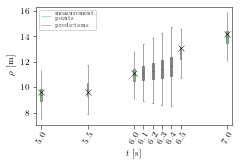

In [456]:
plt.rcParams.update(PLOT_PARAMS)
colors = pl.cm.viridis(jnp.linspace(0., 1., 5))
ticks = jnp.array(sorted(m_timesteps + pred_timesteps))

# plot_width = 7.5
# plt.rcParams.update({'figure.figsize': (plot_width, 2 * plot_width / (1 + jnp.sqrt(5)))})

fig, ax = plt.subplots(1, 1)
sns.boxplot(x="timestep", y="samples", data=m_distance_samples, order=time_order, ax=ax, width=0.2, color=colors[3], showfliers=False)
sns.boxplot(x="timestep", y="samples", data=pred_distance_samples, order=time_order, ax=ax, width=0.2, color=COLOR_GRAY, showfliers=False)
ax.set_xticks((ticks - 5) * 10)
ax.set_xticklabels(ticks, rotation=60);
ax.set_ylabel(r'$\rho$ [m]')
ax.set_xlabel(r'$t$ [s]')
ax.scatter((time[m_mask] - 5) * 10, distance_measured_acc[m_mask], color='k', marker='x')
ax.plot([0], [10], label="measurement\npoints", color=colors[3])
ax.plot([0], [10], label="predictions", color=COLOR_GRAY)
ax.legend()
# ax.fill_between((time[pred_constant_indeces] - 5) * 10, ci_low[pred_constant_indeces], ci_high[pred_constant_indeces], color="tab:gray", alpha=0.2)

plt.savefig("distance_bars.pdf", bbox_inches='tight')

## Draft